In [2]:
from modules import UnivariateLSTM
import torch
import torch.nn as nn
import yfinance as yf

In [3]:
# Device agnostic
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

In [4]:
sp500 = yf.download("^GSPC", period="max", start="2001-1-1")
sp500.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2001-01-02,1320.280029,1320.280029,1276.050049,1283.270020,1283.270020,1129400000
2001-01-03,1283.270020,1347.760010,1274.619995,1347.560059,1347.560059,1880700000
2001-01-04,1347.560059,1350.239990,1329.140015,1333.339966,1333.339966,2131000000
2001-01-05,1333.339966,1334.770020,1294.949951,1298.349976,1298.349976,1430800000
2001-01-08,1298.349976,1298.349976,1276.290039,1295.859985,1295.859985,1115500000


In [5]:
# 对 Close 列进行归一化
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
sp500["Close"] = scaler.fit_transform(sp500["Close"].values.reshape(-1, 1))
sp500.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2001-01-02,1320.280029,1320.280029,1276.050049,0.132539,1283.270020,1129400000
2001-01-03,1283.270020,1347.760010,1274.619995,0.146583,1347.560059,1880700000
2001-01-04,1347.560059,1350.239990,1329.140015,0.143477,1333.339966,2131000000
2001-01-05,1333.339966,1334.770020,1294.949951,0.135833,1298.349976,1430800000
2001-01-08,1298.349976,1298.349976,1276.290039,0.135289,1295.859985,1115500000


In [6]:
eval_model = UnivariateLSTM.load_from_checkpoint(
    checkpoint_path="/Users/raopend/Workspace/stock-index-prediction/notebook/checkpoints/epoch=29-val_loss=0.00-other_metric=0.00.ckpt",
)

In [7]:
def model_forecast(model, series, window_size):
    forecast = []
    for i in range(len(series) - window_size):
        window = series[i : i + window_size]
        window = torch.tensor(window).unsqueeze(0).unsqueeze(-1).float().to(device)
        model.eval()
        with torch.inference_mode():
            forecast.append(model(window).item())
    return forecast

In [8]:
lstm_forecast = model_forecast(eval_model, sp500["Close"].values, 7)

In [9]:
len(lstm_forecast)

5855

In [10]:
len(sp500)

5862

<Axes: xlabel='Date'>

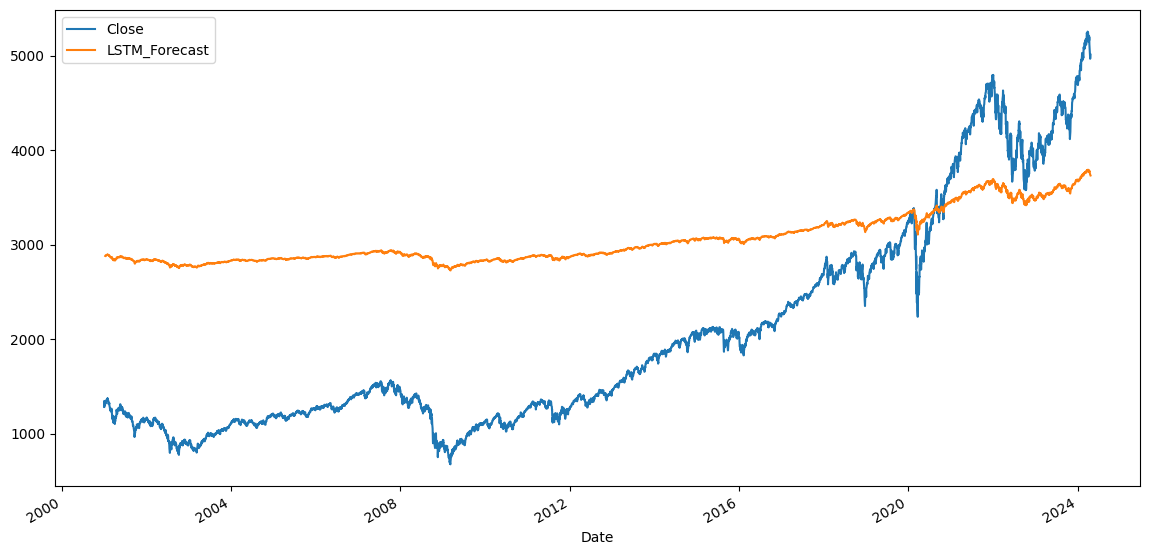

In [11]:
# 为了方便比较，我们将预测值的长度补齐到原始数据的长度
lstm_forecast = [None] * 7 + lstm_forecast
# 将预测值保存到 DataFrame 中
sp500["LSTM_Forecast"] = lstm_forecast
# 反归一化
sp500["LSTM_Forecast"] = scaler.inverse_transform(
    sp500["LSTM_Forecast"].values.reshape(-1, 1)
)
sp500["Close"] = scaler.inverse_transform(sp500["Close"].values.reshape(-1, 1))
# 画折线图
sp500[["Close", "LSTM_Forecast"]].plot(figsize=(14, 7))